In [33]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [34]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

In [35]:
all_dataframes = []
for index, file in enumerate(all_files):
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)
scaler = StandardScaler()
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

Reading file: K120.csv
Finished reading file: K120.csv, shape = (2880, 7)
Reading file: K134.csv
Finished reading file: K134.csv, shape = (2880, 7)
Reading file: K140.csv
Finished reading file: K140.csv, shape = (2880, 5)
Reading file: K159.csv
Finished reading file: K159.csv, shape = (2880, 11)
Reading file: K405.csv
Finished reading file: K405.csv, shape = (2880, 19)
Reading file: K406.csv
Finished reading file: K406.csv, shape = (2880, 8)
Reading file: K701.csv
Finished reading file: K701.csv, shape = (2880, 7)
Reading file: K702.csv
Finished reading file: K702.csv, shape = (2880, 8)
Reading file: K703.csv
Finished reading file: K703.csv, shape = (2880, 10)
Reading file: K709.csv
Finished reading file: K709.csv, shape = (2880, 17)
Reading file: K711.csv
Finished reading file: K711.csv, shape = (2880, 31)


In [36]:
timestamps = combined_df.index
dataset = combined_df.to_numpy()

In [37]:
def splitSequence(seq, n_steps):

    #Declare X and y as empty list
    X = []
    y = []

    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps

        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex, :-2]

        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)

    return X,y

In [38]:
num_of_steps = data.shape[0]
train_size = 0.6
val_size = 0.15
shuffle = True
look_back = 24

x, y = splitSequence(data, look_back)

if shuffle:
    idx = np.random.permutation(len(x))
    x,y = x[idx], y[idx]

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)

x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = x[num_train:num_train + num_val], y[num_train:num_train + num_val]
x_test, y_test = x[num_train + num_val:], y[num_train + num_val:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1728, 24, 132)
(432, 24, 132)
(696, 24, 132)


In [39]:

#Add params to do optimizing at the top
input_dim = data.shape[1]
output_size = y_train.shape[1]
testScores1 = []
for units in [2, 4, 10, 20, 40, 60, 80, 100]:
    intTestScores = np.empty(0)
    for i in range(3):
        input = keras.Input((look_back, input_dim))
        #return sequences is necessary for sequential LSTM layers
        lstm1 = LSTM(units)(input)
        out = Dense(output_size)(lstm1)
        model = keras.models.Model(inputs=input, outputs=out)
        model.summary()

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=0.001),
            metrics=[keras.metrics.RootMeanSquaredError()],
        )

        history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=500,
            #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
        )

        # make predictions
        trainPredict = model.predict(x_train)
        testPredict = model.predict(x_test)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform(y_train)
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform(y_test)
        # calculate root mean squared error
        trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
        print(f'Train Score: {trainScore:.2f} RMSE')
        testScore = np.sqrt(mean_squared_error(testY, testPredict))
        print(f'Test Score: {testScore:.2f} RMSE')
        intTestScores = np.append(intTestScores, testScore)
    testScores1.append(np.mean(intTestScores))

Model: "model_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_105 (InputLayer)      [(None, 24, 132)]         0         
                                                                 
 lstm_135 (LSTM)             (None, 2)                 1080      
                                                                 
 dense_104 (Dense)           (None, 130)               390       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 1s 9ms/step - loss: 0.9529 - root_mean_squared_error: 0.9762 - val_loss: 0.9785 - val_root_mean_squared_error: 0.9892
Epoch 2/500
54/54 [==============================] - 0s 4ms/step - loss: 0.8320 - root_mean_squared_error: 0.9121 - val_loss: 0.8523 - val_root_mean

In [40]:

#Add params to do optimizing at the top
input_dim = data.shape[1]
output_size = y_train.shape[1]
testScores2 = []
for units in [2, 4, 10, 20, 40, 60, 80, 100]:
    intTestScores = np.empty(0)
    for i in range(3):
        input = keras.Input((look_back, input_dim))
        #return sequences is necessary for sequential LSTM layers
        lstm1 = LSTM(units, return_sequences=True)(input)
        lstm2 = LSTM(units)(lstm1)
        out = Dense(output_size)(lstm2)
        model = keras.models.Model(inputs=input, outputs=out)
        model.summary()

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=0.001),
            metrics=[keras.metrics.RootMeanSquaredError()],
        )

        history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=500,
            #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
        )

        # make predictions
        trainPredict = model.predict(x_train)
        testPredict = model.predict(x_test)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform(y_train)
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform(y_test)
        # calculate root mean squared error
        trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
        print(f'Train Score: {trainScore:.2f} RMSE')
        testScore = np.sqrt(mean_squared_error(testY, testPredict))
        print(f'Test Score: {testScore:.2f} RMSE')
        intTestScores = np.append(intTestScores, testScore)
    testScores2.append(np.mean(intTestScores))

Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_129 (InputLayer)      [(None, 24, 132)]         0         
                                                                 
 lstm_159 (LSTM)             (None, 24, 2)             1080      
                                                                 
 lstm_160 (LSTM)             (None, 2)                 40        
                                                                 
 dense_128 (Dense)           (None, 130)               390       
                                                                 
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 3s 18ms/step - loss: 0.9864 - root_mean_squared_error: 0.9932 - val_loss: 1.0554 - val_root_mean_squared_error: 1.0273
Epoch 2/500
54/

In [41]:

#Add params to do optimizing at the top
input_dim = data.shape[1]
output_size = y_train.shape[1]
testScores3 = []
for units in [2, 4, 10, 20, 40, 60, 80, 100]:
    intTestScores = np.empty(0)
    for i in range(3):
        input = keras.Input((look_back, input_dim))
        #return sequences is necessary for sequential LSTM layers
        lstm1 = LSTM(units, return_sequences=True)(input)
        lstm2 = LSTM(units)(lstm1)
        out = Dense(output_size)(lstm2)
        model = keras.models.Model(inputs=input, outputs=out)
        model.summary()

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=0.001),
            metrics=[keras.metrics.RootMeanSquaredError()],
        )

        history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=500,
            #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
        )

        # make predictions
        trainPredict = model.predict(x_train)
        testPredict = model.predict(x_test)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform(y_train)
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform(y_test)
        # calculate root mean squared error
        trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
        print(f'Train Score: {trainScore:.2f} RMSE')
        testScore = np.sqrt(mean_squared_error(testY, testPredict))
        print(f'Test Score: {testScore:.2f} RMSE')
        intTestScores = np.append(intTestScores, testScore)
    testScores3.append(np.mean(intTestScores))

Model: "model_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_153 (InputLayer)      [(None, 24, 132)]         0         
                                                                 
 lstm_207 (LSTM)             (None, 24, 2)             1080      
                                                                 
 lstm_208 (LSTM)             (None, 2)                 40        
                                                                 
 dense_152 (Dense)           (None, 130)               390       
                                                                 
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 3s 17ms/step - loss: 0.9713 - root_mean_squared_error: 0.9855 - val_loss: 1.0168 - val_root_mean_squared_error: 1.0084
Epoch 2/500
54/

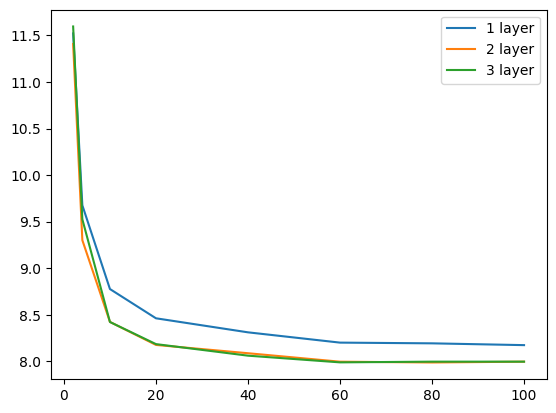

In [44]:
plt.plot([2, 4, 10, 20, 40, 60, 80, 100], testScores1, label='1 layer')
plt.plot([2, 4, 10, 20, 40, 60, 80, 100], testScores2, label='2 layer')
plt.plot([2, 4, 10, 20, 40, 60, 80, 100], testScores3, label='3 layer')
plt.legend()

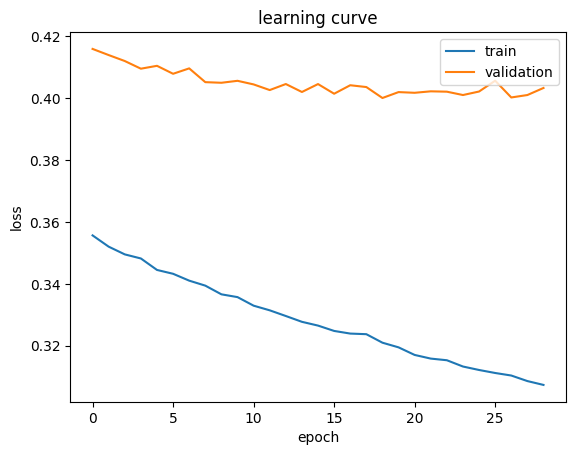

In [43]:
plt.plot(history.history['root_mean_squared_error'][5:], label='train')
plt.plot(history.history['val_root_mean_squared_error'][5:], label='validation')
plt.title("learning curve")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()